In [1]:
import torch
import torch.nn as nn
import lightning as L
import matplotlib.pyplot as plt
import torchvision
import numpy as np

from torchvision.transforms import Compose, ToTensor


# Lab 5: PyTorch Lightning

In [2]:
train_dataset = torchvision.datasets.CIFAR10("/results/mgazda/cifar_10/train", train=True,
                                                  download=True)
validation_dataset = torchvision.datasets.CIFAR10("/results/mgazda/cifar_10/valid", train=False,
                                                  download=True)

In [ ]:
labels = []

for i in train_dataset:
    labels.append(i[1])

import numpy as np
np.unique(labels)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## CIFAR-10 Dataset

train_dataset length:  50000
validation_dataset length:  10000


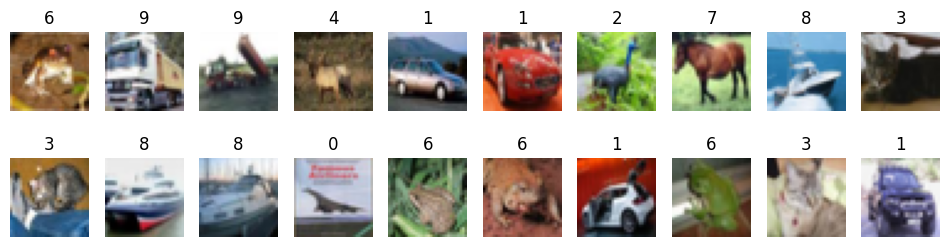

In [4]:
samples = 10
fig, axs = plt.subplots(2, samples, figsize=(12, 3))

for i in range(samples):
    axs[0][i].set_title(train_dataset[i][1])
    axs[0][i].imshow(train_dataset[i][0])
    axs[1][i].set_title(validation_dataset[i][1])
    axs[1][i].imshow(validation_dataset[i][0])
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    
print('train_dataset length: ', len(train_dataset))
print('validation_dataset length: ', len(validation_dataset))

### Sample Images

In [5]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(self, batch_size=32, train_transform=None, val_transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.train_dataset = torchvision.datasets.CIFAR10("/results/mgazda/cifar_10/train", train=True,
                                                  download=True, transform=train_transform)
        self.validation_dataset = torchvision.datasets.CIFAR10("/results/mgazda/cifar_10/valid", train=False,
                                                  download=True, transform=val_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False)
    

## DataModule

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Test set should only be normalized
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])



## Data Augmentation

In [ ]:

from typing import Any
import seaborn as sns

from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.classification import MulticlassAccuracy

class CIFAR10Model(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512*5*5, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.train_acc = MulticlassAccuracy(10)
        self.val_acc = MulticlassAccuracy(10)
        self.val_cm = MulticlassConfusionMatrix(10, normalize='true')
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                    'dog', 'frog', 'horse', 'ship', 'truck']
        
    def forward(self, x):
        return self.network(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        acc = self.train_acc(y_pred, y)
        
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        
        # Update metrics
        self.val_acc.update(y_pred, y)
        self.val_cm.update(y_pred, y)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_validation_epoch_end(self):
        # Compute final metrics
        val_acc = self.val_acc.compute()
        self.log('val_acc', val_acc, prog_bar=True)
        
        # Compute confusion matrix
        cm = self.val_cm.compute()
        
        # Create matplotlib figure
        fig = self.plot_confusion_matrix(cm)
        
        # Log to TensorBoard
        if self.logger is not None:
            self.logger.experiment.add_figure(
                'confusion_matrix',
                fig,
                global_step=self.current_epoch
            )
        
        plt.close(fig)  # Close to free memory
        
        # Reset metrics for next epoch
        self.val_acc.reset()
        self.val_cm.reset()
    
    def plot_confusion_matrix(self, cm):
        """Create a matplotlib figure for the confusion matrix"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Convert to numpy if needed
        cm_numpy = cm.cpu().numpy()
        
        # Create heatmap
        sns.heatmap(cm_numpy, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names,
                    ax=ax, cbar_kws={'label': 'Normalized Count'})
        
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_title(f'Confusion Matrix (Epoch {self.current_epoch})', fontsize=14)
        
        plt.tight_layout()
        return fig

## LightningModule

In [16]:
tb_logger = L.pytorch.loggers.TensorBoardLogger("lab_metrics", "cifar10")
model = CIFAR10Model()
dm = CIFAR10DataModule(batch_size=64, train_transform=train_transform, val_transform=val_transform)
trainer = L.Trainer(accelerator='cuda', devices=1, max_epochs=20, logger=tb_logger)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Training Setup

In [17]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | network   | Sequential                | 4.0 M  | train
1 | loss      | CrossEntropyLoss          | 0      | train
2 | train_acc | MulticlassAccuracy        | 0      | train
3 | val_acc   | MulticlassAccuracy        | 0      | train
4 | val_cm    | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.867    Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 193.87it/s]

/home/mgazda/Projects/nn_labs/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/mgazda/Projects/nn_labs/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 782/782 [00:12<00:00, 65.15it/s, v_num=2, val_loss=1.230, val_acc=0.698, train_loss=0.185, train_acc=0.940] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 782/782 [00:12<00:00, 64.82it/s, v_num=2, val_loss=1.230, val_acc=0.698, train_loss=0.185, train_acc=0.940]


## Training